c:\Users\tutha\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\utils\passive_env_checker.py:159: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")
c:\Users\tutha\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.get_obs to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.get_obs` for environment variables or `env.get_wrapper_attr('get_obs')` that will search the reminding wrappers.
  logger.warn(
c:\Users\tutha\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\utils\passive_env_checker.py:159: UserWarning: WARN: The obs returned by the `step()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")


Update 0, Loss: 14904.9033203125, Policy Loss: -353.2114562988281, Value Loss: 30516.271484375, Entropy: 2.078509012110093, Epsiode Reward: -1627.25


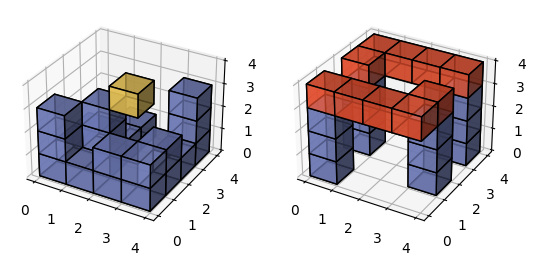

tensor([[0.1214, 0.1215, 0.1297, 0.1285, 0.1173, 0.1211, 0.1253, 0.1352]],
       device='cuda:0', grad_fn=<SoftmaxBackward0>)
Update 1, Loss: 0.18251124024391174, Policy Loss: 0.19871175289154053, Value Loss: 0.009168107062578201, Entropy: 2.078457869641921, Epsiode Reward: -1717.25
Update 2, Loss: 0.2323603481054306, Policy Loss: 0.2461218237876892, Value Loss: 0.014044239185750484, Entropy: 2.0783593284382538, Epsiode Reward: -1722.5
Update 3, Loss: 0.2578616738319397, Policy Loss: 0.2702227234840393, Value Loss: 0.016845323145389557, Entropy: 2.0783713497835046, Epsiode Reward: -1652
Update 4, Loss: 0.24933649599552155, Policy Loss: 0.26214849948883057, Value Loss: 0.01594407856464386, Entropy: 2.07840406109305, Epsiode Reward: -1733
Update 5, Loss: 0.23263993859291077, Policy Loss: 0.24638347327709198, Value Loss: 0.014079960994422436, Entropy: 2.0783507922116446, Epsiode Reward: -1837
Update 6, Loss: 0.20694689452648163, Policy Loss: 0.22201508283615112, Value Loss: 0.01143012940

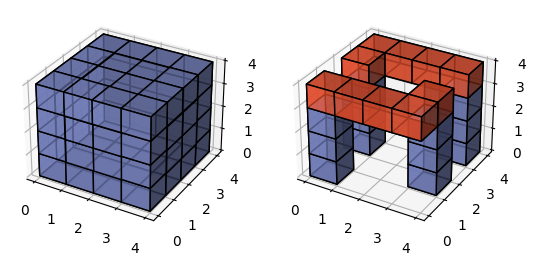

tensor([[0.1213, 0.1241, 0.1281, 0.1278, 0.1171, 0.1184, 0.1243, 0.1389]],
       device='cuda:0', grad_fn=<SoftmaxBackward0>)
Update 11, Loss: 0.03812694549560547, Policy Loss: 0.05851128697395325, Value Loss: 0.0007923127268441021, Entropy: 2.078049771084505, Epsiode Reward: -1706


KeyboardInterrupt: 

In [5]:
from typing import final
import GridWorld_env
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
from itertools import count
from replay_buffer import ReplayBuffer
import matplotlib
from collections import namedtuple

is_ipython = "inline" in matplotlib.get_backend()
if is_ipython:
    from IPython import display

Transition = namedtuple("Transition", ("state", "action", "next_state", "reward", "done"))


class ActorCritic(nn.Module):
    def __init__(self, input_dim, action_dim):
        super(ActorCritic, self).__init__()

        self.conv1 = nn.Conv3d(3, 29, 3, 1, 1)

        self.conv2 = nn.Conv3d(32, 67, 3, 1, 1)

        self.fc1 = nn.Linear((64 + 3*2)*input_dim * input_dim * input_dim, 1024)

        self.critic = nn.Sequential(
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )

        self.actor = nn.Sequential(
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Linear(256, action_dim),
            nn.Softmax(dim=-1)
        )

    def forward(self, x):
        original_state = x

        x = self.conv1(x)

        x = torch.cat([x, original_state], dim=1)
        x = F.relu(x)

        x = self.conv2(x)
        x = torch.cat([x, original_state], dim=1)

        x = F.relu(x)
        x = nn.Flatten()(x)
        x = self.fc1(x)
        x = F.relu(x)

        value = self.critic(x)
        probs = self.actor(x)
        dist = torch.distributions.Categorical(probs)
        action = dist.sample()
        log_prob = dist.log_prob(action)
        entropy = dist.entropy().mean()
            
        return action, log_prob, entropy, value.squeeze(0), probs


class RolloutStorage(object):
    def __init__(self, rollout_size, num_envs, feature_size, is_cuda=True, value_coeff=0.5, entropy_coeff=0.2, writer=None):
        super().__init__()
        
        self.rollout_size = rollout_size
        self.num_envs = num_envs
        self.feature_size = feature_size
        self.is_cuda = is_cuda
        self.value_coeff = value_coeff
        self.entropy_coeff = entropy_coeff
        self.writer = writer
        
        self.rewards = self._reset_buffer_with_zero((rollout_size, num_envs))
        self.states = self._reset_buffer_with_zero((rollout_size + 1, num_envs, 3, feature_size, feature_size, feature_size))
        self.actions = self._reset_buffer_with_zero((rollout_size, num_envs))
        self.log_probs = self._reset_buffer_with_zero((rollout_size, num_envs))
        self.values = self._reset_buffer_with_zero((rollout_size, num_envs))
        self.dones = self._reset_buffer_with_zero((rollout_size, num_envs))
        
    
    def _reset_buffer_with_zero(self, size):
        if self.is_cuda:
            return torch.zeros(size).cuda()
        return torch.zeros(size)
    
    def insert(self, step, reward, obs, action, log_prob, value, dones):
        self.rewards[step].copy_(torch.tensor(reward))
        self.states[step+1].copy_(torch.from_numpy(obs))
        self.actions[step].copy_(action)
        self.log_probs[step].copy_(log_prob)
        self.values[step].copy_(value)
        
        self.dones[step].copy_(dones)
        
    def _discount_rewards(self, final_value, discount=0.99):
        r_discounted = self._reset_buffer_with_zero((self.rollout_size, self.num_envs))
        R = self._reset_buffer_with_zero(self.num_envs).masked_scatter((1 - self.dones[-1]).bool(), final_value)
        
        #print(self.dones[0].dtype)
        #R = R.to(self.rewards.device)
        for i in reversed(range(self.rollout_size)):
            #print(self.dones[i].device, self.rewards[i].device, R.device)
            R = self._reset_buffer_with_zero(self.num_envs).masked_scatter((1 - self.dones[i]).bool(), self.rewards[i] + discount * R)
            r_discounted[i] = R 
            
        return r_discounted
    
    def compute_a2c_loss(self, final_value, entropy):
        rewards = self._discount_rewards(final_value)
        advantages = rewards - self.values
        
        policy_loss = (-self.log_probs * advantages.detach()).mean()
        
        value_loss = advantages.pow(2).mean()
        
        loss = policy_loss + self.value_coeff * value_loss - self.entropy_coeff * entropy
        
        return loss, policy_loss, value_loss, entropy

    def get_state(self, step):
        return self.states[step].clone()
    
    def after_update(self):
        self.states[0].copy_(self.states[-1])
        self.actions = self._reset_buffer_with_zero((self.rollout_size, self.num_envs))
        self.log_probs = self._reset_buffer_with_zero((self.rollout_size, self.num_envs))
        self.values = self._reset_buffer_with_zero((self.rollout_size, self.num_envs))
        
    


class Runner:
    def __init__(self, net, env, num_envs, rollout_size, num_updates, max_grad_norm, value_coeff=0.5, entropy_coeff=0.01, tensorboard_log = False, log_path="./log", is_cuda = True):
        self.num_envs = num_envs
        self.rollout_size = rollout_size
        self.num_updates = num_updates
        
        self.max_grad_norm = max_grad_norm
        
        self.is_cuda = torch.cuda.is_available() and is_cuda
        self.writer = None
        
        
        self.env = env
        self.storage = RolloutStorage(rollout_size, num_envs, 4, self.is_cuda, value_coeff, entropy_coeff, self.writer)
        
        self.net = net
        
        if self.is_cuda:
            self.net.cuda()
            
    def train(self, optimizer):
        self.env.reset()
        obs = self.env.get_obs()
        self.storage.states[0].copy_(torch.from_numpy(obs))
        best_loss = np.inf
        
        
        for num_update in range(self.num_updates):
            final_value, episode_entropy, cummulative_reward, softmax_policy_out = self.episode_rollout()
            opt.zero_grad()

            
            loss, policy_loss, value_loss, entropy = self.storage.compute_a2c_loss(final_value, episode_entropy)
            loss.backward()
            
            nn.utils.clip_grad_norm_(self.net.parameters(), self.max_grad_norm)
            optimizer.step()
            
            print(f"Update {num_update}, Loss: {loss.item()}, Policy Loss: {policy_loss.item()}, Value Loss: {value_loss.item()}, Entropy: {entropy}, Epsiode Reward: {cummulative_reward}")
            
            self.storage.after_update()
            
            if num_update % 10 == 0:
                self.env.render()
                print(softmax_policy_out)
            
        
        
    def episode_rollout(self):
        episode_entropy = 0
        cummulative_reward = 0
        for step in range(self.rollout_size):
            
            action, log_prob, entropy, value, a2c_features = self.net(self.storage.get_state(step))
            episode_entropy += entropy.item()
            #print(action, log_prob, entropy, value, a2c_features)
            obs, reward, terminated, dones, _ = self.env.step(action.cpu().numpy())
            #print(dones)
            self.storage.insert(step, reward, obs, action, log_prob, value, dones)
            cummulative_reward += reward
        with torch.no_grad():
            _, _, _, final_value, _ = self.net(self.storage.get_state(step + 1))
        return final_value, episode_entropy/self.rollout_size, cummulative_reward, a2c_features


n_actions = 8
env = gym.make("GridWorld_env/GridWorld", dimension_size=4, path="targets")
net = ActorCritic(4, n_actions)
runner = Runner(net=net, env=env, num_envs=1, rollout_size=850, num_updates=100, max_grad_norm=10, value_coeff=0.5, entropy_coeff=0.01, tensorboard_log=False, log_path="./log", is_cuda=True)

opt = optim.Adam(net.parameters(), lr=0.0000625)
runner.train(opt)

    

In [6]:

env.reset()
for i in count():
    
    action, _, _, _, _ = net(torch.from_numpy(env.get_obs()).unsqueeze(0).float().cuda())
    env.step(action.cpu().numpy())
    env.render()
    display.clear_output(wait=True)
    


KeyboardInterrupt: 